<a href="https://colab.research.google.com/github/KofiAnaan0/FeatureEngineering/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Uploading the file using google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/My Drive/clean_data_after_eda.csv')
df['date_activ'] = pd.to_datetime(df['date_activ'], format='%Y-%m-%d')
df['date_end'] = pd.to_datetime(df['date_end'], format='%Y-%m-%d')
df['date_modif_prod'] = pd.to_datetime(df['date_modif_prod'], format='%Y-%m-%d')
df['date_renewal'] = pd.to_datetime(df['date_renewal'], format='%Y-%m-%d')
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


# Feature Engineering
Difference between off-peak prices in December and preceding January

In [ ]:
price_data = pd.read_csv('/content/drive/My Drive/BCGX/price_data.csv')
price_data['price_date'] = pd.to_datetime(price_data['price_date'], format='%d/%m/%Y')
price_data.head(3)

,id,price_date,price of energy for the 1st period (off peak),price of energy for the 2nd period (peak),price of energy for the 3rd period (mid peak),price of power for the 1st period (off peak),price of power for the 2nd period (peak),price of power for the 3rd period (mid peak)
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [ ]:
#Strip leading/trailing space from column names
price_data.columns = price_data.columns.str.strip()

#Replace ' ' between words in column name with '_'
price_data.columns = price_data.columns.str.replace(' ', '_')
print(price_data.columns)

Index(['id', 'price_date', 'price_of_energy_for_the_1st_period_(off_peak)',
       'price_of_energy_for_the_2nd_period_(peak)',
       'price_of_energy_for_the_3rd_period_(mid_peak)',
       'price_of_power_for_the_1st_period_(off_peak)',
       'price_of_power_for_the_2nd_period_(peak)',
       'price_of_power_for_the_3rd_period_(mid_peak)'],
      dtype='object')


In [ ]:
#Group off-peak by company & month
monthly_price_by_id = price_data.groupby(['id', 'price_date']).agg({'price_of_energy_for_the_1st_period_(off_peak)': 'mean', 'price_of_power_for_the_1st_period_(off_peak)': 'mean'}).reset_index()

#Get January &  December price
jan_price_by_id = monthly_price_by_id.groupby('id').first().reset_index()
dec_price_by_id = monthly_price_by_id.groupby('id').last().reset_index()

#Calculate the difference
diff = pd.merge(dec_price_by_id.rename(columns={'price_of_energy_for_the_1st_period_(off_peak)': 'dec_price_of_energy_for_the_1st_period_(off_peak)', 'price_of_power_for_the_1st_period_(off_peak)':'dec_price_of_power_for_the_1st_period_(off_peak)'}), jan_price_by_id.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_price_of_energy_for_the_1st_period_(off_peak)'] - diff['price_of_energy_for_the_1st_period_(off_peak)']
diff['offpeak_diff_dec_january_power'] = diff['dec_price_of_power_for_the_1st_period_(off_peak)'] - diff['price_of_power_for_the_1st_period_(off_peak)']
diff = diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]
diff.head(3)

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000


In [ ]:
#Merging the engineered feature to the cleaned dataset
df = pd.merge(df, diff, on='id')
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0,-0.004670,0.177779


# Average price changes across periods
Enhancing the feature by calculating the average price changes across individual periods, instead of the entire year.

In [ ]:
# Aggregate average prices per period by company
mean_prices_by_month = price_data.groupby(['id', 'price_date']).agg({
    'price_of_energy_for_the_1st_period_(off_peak)': 'mean',
    'price_of_energy_for_the_2nd_period_(peak)': 'mean',
    'price_of_energy_for_the_3rd_period_(mid_peak)': 'mean',
    'price_of_power_for_the_1st_period_(off_peak)': 'mean',
    'price_of_power_for_the_2nd_period_(peak)': 'mean',
    'price_of_power_for_the_3rd_period_(mid_peak)': 'mean'
}).reset_index()
mean_prices_by_month.head(3)

,id,price_date,price_of_energy_for_the_1st_period_(off_peak),price_of_energy_for_the_2nd_period_(peak),price_of_energy_for_the_3rd_period_(mid_peak),price_of_power_for_the_1st_period_(off_peak),price_of_power_for_the_2nd_period_(peak),price_of_power_for_the_3rd_period_(mid_peak)
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555


In [ ]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   id                                             193002 non-null  object        
 1   price_date                                     193002 non-null  datetime64[ns]
 2   price_of_energy_for_the_1st_period_(off_peak)  193002 non-null  float64       
 3   price_of_energy_for_the_2nd_period_(peak)      193002 non-null  float64       
 4   price_of_energy_for_the_3rd_period_(mid_peak)  193002 non-null  float64       
 5   price_of_power_for_the_1st_period_(off_peak)   193002 non-null  float64       
 6   price_of_power_for_the_2nd_period_(peak)       193002 non-null  float64       
 7   price_of_power_for_the_3rd_period_(mid_peak)   193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
m

In [ ]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_energy_mean_diff'] = mean_prices_by_month['price_of_energy_for_the_1st_period_(off_peak)'] - mean_prices_by_month['price_of_energy_for_the_2nd_period_(peak)']
mean_prices_by_month['peak_mid_peak_energy_mean_diff'] = mean_prices_by_month['price_of_energy_for_the_2nd_period_(peak)'] - mean_prices_by_month['price_of_energy_for_the_3rd_period_(mid_peak)']
mean_prices_by_month['off_peak_mid_peak_energy_mean_diff'] = mean_prices_by_month['price_of_energy_for_the_1st_period_(off_peak)'] - mean_prices_by_month['price_of_energy_for_the_3rd_period_(mid_peak)']
mean_prices_by_month['off_peak_peak_power_mean_diff'] = mean_prices_by_month['price_of_power_for_the_1st_period_(off_peak)'] - mean_prices_by_month['price_of_power_for_the_2nd_period_(peak)']
mean_prices_by_month['peak_mid_peak_power_mean_diff'] = mean_prices_by_month['price_of_power_for_the_2nd_period_(peak)'] - mean_prices_by_month['price_of_power_for_the_3rd_period_(mid_peak)']
mean_prices_by_month['off_peak_mid_peak_power_mean_diff'] = mean_prices_by_month['price_of_power_for_the_1st_period_(off_peak)'] - mean_prices_by_month['price_of_power_for_the_3rd_period_(mid_peak)']
mean_prices_by_month.head(3)

,id,price_date,price_of_energy_for_the_1st_period_(off_peak),price_of_energy_for_the_2nd_period_(peak),price_of_energy_for_the_3rd_period_(mid_peak),price_of_power_for_the_1st_period_(off_peak),price_of_power_for_the_2nd_period_(peak),price_of_power_for_the_3rd_period_(mid_peak),off_peak_peak_energy_mean_diff,peak_mid_peak_energy_mean_diff,off_peak_mid_peak_energy_mean_diff,off_peak_peak_power_mean_diff,peak_mid_peak_power_mean_diff,off_peak_mid_peak_power_mean_diff
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330


In [ ]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_energy_mean_diff': 'max',
    'peak_mid_peak_energy_mean_diff': 'max',
    'off_peak_mid_peak_energy_mean_diff': 'max',
    'off_peak_peak_power_mean_diff': 'max',
    'peak_mid_peak_power_mean_diff': 'max',
    'off_peak_mid_peak_power_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_energy_mean_diff': 'off_peak_peak_energy_max_monthly_diff',
        'peak_mid_peak_energy_mean_diff': 'peak_mid_peak_energy_max_monthly_diff',
        'off_peak_mid_peak_energy_mean_diff': 'off_peak_mid_peak_energy_max_monthly_diff',
        'off_peak_peak_power_mean_diff': 'off_peak_peak_power_max_monthly_diff',
        'peak_mid_peak_power_mean_diff': 'peak_mid_peak_power_max_monthly_diff',
        'off_peak_mid_peak_power_mean_diff': 'off_peak_mid_peak_power_max_monthly_diff'
    }
)
max_diff_across_periods_months.head(3)

,id,off_peak_peak_energy_max_monthly_diff,peak_mid_peak_energy_max_monthly_diff,off_peak_mid_peak_energy_max_monthly_diff,off_peak_peak_power_max_monthly_diff,peak_mid_peak_power_max_monthly_diff,off_peak_mid_peak_power_max_monthly_diff
0,0002203ffbb812588b632b9e628cc38d,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.000000,0.148405,44.444710,0.000000,44.44471
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.000000,0.205742,45.944710,0.000000,45.94471


In [ ]:
print(max_diff_across_periods_months.columns)

Index(['id', 'off_peak_peak_energy_max_monthly_diff',
       'peak_mid_peak_energy_max_monthly_diff',
       'off_peak_mid_peak_energy_max_monthly_diff',
       'off_peak_peak_power_max_monthly_diff',
       'peak_mid_peak_power_max_monthly_diff',
       'off_peak_mid_peak_power_max_monthly_diff'],
      dtype='object')


In [ ]:
#Merge the engineered feature
columns = [
    'id',
    'off_peak_peak_energy_max_monthly_diff',
    'peak_mid_peak_energy_max_monthly_diff',
    'off_peak_mid_peak_energy_max_monthly_diff',
    'off_peak_peak_power_max_monthly_diff',
    'peak_mid_peak_power_max_monthly_diff',
    'off_peak_mid_peak_power_max_monthly_diff'
]
df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_energy_max_monthly_diff,peak_mid_peak_energy_max_monthly_diff,off_peak_mid_peak_energy_max_monthly_diff,off_peak_peak_power_max_monthly_diff,peak_mid_peak_power_max_monthly_diff,off_peak_mid_peak_power_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,44.236702,1,0.020057,3.700961,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0,-0.003767,0.177779,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0,-0.004670,0.177779,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471


 **The reason why Max monthly prices across periods was calculated**.
 As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn

# Tenure
How long a company has been a client of PowerCo.

In [ ]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'D')/ 365.25).astype(int)
df['tenure'].head(3)

,tenure
0,3
1,7
2,6


In [ ]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False).head(3)

,churn
tenure,
3,0.143713
2,0.133080
4,0.125756


We can see that companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

# Transforming dates into months
- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [ ]:
#Converting dates to months
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = ((time_delta / np.timedelta64(1, 'D'))/ 30.44).astype(int)
    return months

In [ ]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

Using intuition, you could assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the months_activ feature.

As well as this, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think months_to_end will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe months_modif_prod will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe months_renewal will be a good feature to include.

In [ ]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_energy_max_monthly_diff,off_peak_mid_peak_energy_max_monthly_diff,off_peak_peak_power_max_monthly_diff,peak_mid_peak_power_max_monthly_diff,off_peak_mid_peak_power_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.085483,0.151367,44.44471,0.000000,44.44471,7,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.089162,0.172468,44.44471,0.000000,44.44471,6,68,3,68,8


# Transforming Boolean data
has_gas
We simply want to transform this column from being categorical to being a binary flag

In [ ]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

<ipython-input-17-fa80f5127aae>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])


,churn
has_gas,
0,0.100544
1,0.081856


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

# Transforming categorical data
A predictive model cannot accept categorical or string values, hence categorical features are encoded  into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present 0 < 1 < 2 < 3 ...

Another way to encode categorical features is to use dummy variables AKA one hot encoding. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

channel_sales

In [ ]:
#Transform in to category
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

,count
channel_sales,
foosdfpfkusacimwkcsosbicdxkicaua,6754
MISSING,3725
lmkebamcaaclubfxadlmueccxoimlema,1843
usilxuppasemubllopkaafesmlibmsdf,1375
ewpakwlliwisiwduibdlfmalxowmwpci,893
sddiedcslfslkckwlfkdpoeeailfpeds,11
epumfxlbckeskwekxbiuasklxalciiuu,3
fixdbufsefwooaasfcxdxadsiekoceaa,2


We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 categories.

In [ ]:
# Creating dumies
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
dummy_cols = [col for col in df.columns if col.startswith('channel_')]
df[dummy_cols] = df[dummy_cols].astype(int)
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head(3)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,3,30,5,2,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,76,7,76,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,6,68,3,68,8,0,0,1,0,0


# origin_up

In [ ]:
# Transform to category
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

,count
origin_up,
lxidpiddsbxsbosboudacockeimpuepw,7097
kamkkxfxxuwbdslkwifmmcsiusiuosws,4294
ldkssxwpmemidmecebumciepifcamkci,3148
MISSING,64
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


Similar to channel_sales the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [ ]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
dummy_cols = [col for col in df.columns if col.startswith('origin_up_')]
df[dummy_cols] = df[dummy_cols].astype(int)
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head(3)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0


# Transforming numerical data
In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called parametric models, and they typically assume that all variables are both independent and normally distributed.

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:

Square root
Cubic root
Logarithm
to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features.

Note: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

In [ ]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [ ]:
# log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df['imp_cons'] = np.log10(df['imp_cons'] + 1)

In [ ]:
df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,...,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056,...,35.459469,4.910516,0.255032,0.061139,0.462413,0.126181,0.094139,0.293989,0.215528,0.485896
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988,...,30.243894,3.795906,0.435894,0.239594,0.498602,0.332065,0.292033,0.455602,0.411202,0.499818
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701,...,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378,...,30.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378,...,64.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378,...,151.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-35-662fd9adb543>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cons_12m'].dropna(), ax=axs[0])
<ipython-input-35-662fd9adb543>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df['has_gas'] == 1]['cons_gas_12m']).dropna(), ax=axs[1])
<ipython-input-35-662fd9adb543>:6: U

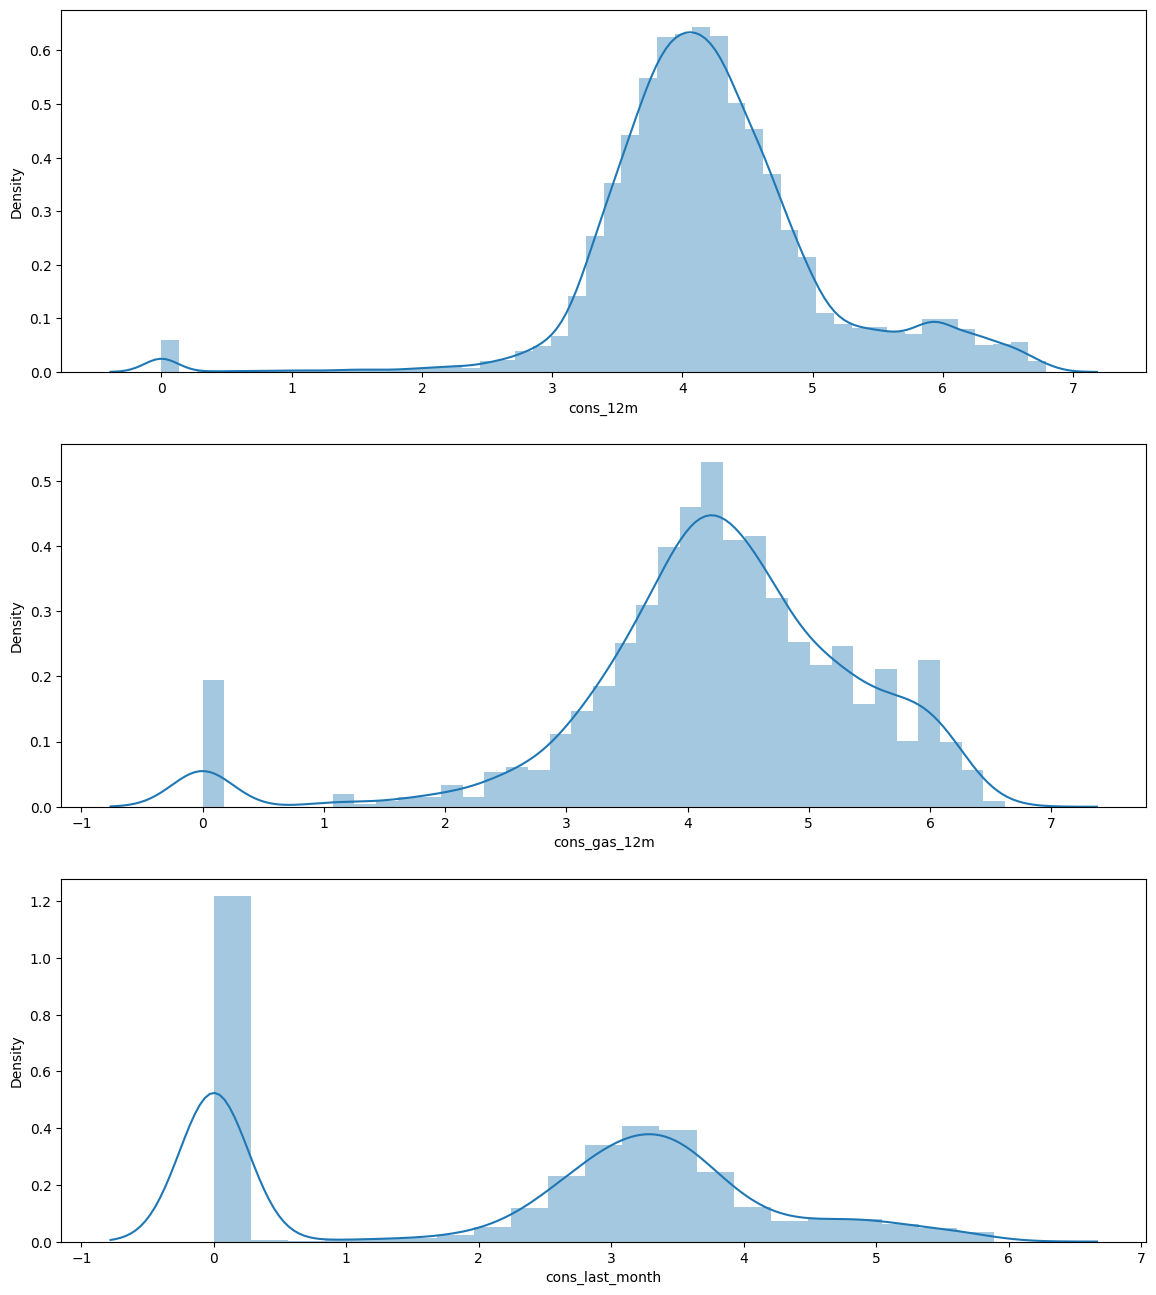

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 16))

# Plot histogram
sns.distplot(df['cons_12m'].dropna(), ax=axs[0])
sns.distplot((df[df['has_gas'] == 1]['cons_gas_12m']).dropna(), ax=axs[1])
sns.distplot(df['cons_last_month'].dropna(), ax=axs[2])

# Plot the graph
plt.show()